# Time-stepper for ODEs
In this notebook we will show how to train a neural network to intelligently choose optimal step sizes in ordinary differential equation integration. The ODE that we want to solve will be given by the Lorenz system, i.e.
    $$ \frac{d}{dt} \begin{bmatrix} x_1 \\
            x_2 \\
            x_3
       \end{bmatrix} = \begin{bmatrix} \sigma (x_2 - x_1) \\
            x_1 (\rho - x_3) - x_2 \\
            x_1 x_2 - \beta x_3
       \end{bmatrix}$$
where $\sigma = 10$, $\beta = \tfrac{8}{3}$, and $\rho = 28$. We aim to integrate this ODE from initial conditions $t_0 = 0$, $x_0 = [10, 10, 10]^T$ until $t_1 = 200$. <br>
Let us first gather some information about the system in the following variables:

In [1]:
import numpy as np

x0 = np.array([10, 10, 10])  # start point of integration
t0 = 0
t1 = 200
d = 3  # dimension of the ODE state space

step_sizes = [0.025, 0.029, 0.033, 0.039, 0.045, 0.052, 0.060, 0.070]  # the NN will choose from these step sizes
tol = 0.0001  # target integration error tolerance

For the integration itself we will use the Dormand-Prince Runge Kutta method (RKDP) of order 5. Thus, we define the following variables as a preparation for creating the NN:

In [2]:
from adaptive.integrator import RKDP
integrator = RKDP()

nodes_per_step = 6  # the RKDP method as 6 stages
dim_action = len(step_sizes)  # the dimension of the action space of the NN
memory = 0  # how many integration steps the predictor can look back

Furthermore, it is a good idea to scale the inputs of the NN to order $\approx 10^{-1}$. For this purpose we will use a scikit-learn StandardScaler. Note that the input dimension of the NN is given by `nodes_per_step * d + 1`.

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.mean_ = np.zeros((nodes_per_step * d + 1) * (memory + 1))
scaler.mean_[0] = -0.045
scaler.scale_ = 10 * np.ones((nodes_per_step * d + 1) * (memory + 1))
scaler.scale_[0] = 0.1

Now we can finally initialize the NN. It is encapsuled by the Predictor object, which handles the interaction with the NN. The NN itself is created using tensorflow.

In [4]:
from adaptive.predictor import PredictorQODE
from adaptive.build_models import build_value_modelODE

predictor = PredictorQODE(step_sizes=step_sizes,
                          model=build_value_modelODE(dim_state=nodes_per_step * d + 1,
                                                     dim_action=dim_action,
                                                     memory=memory),
                          scaler=scaler)

During the training process, we have to reward or penalize the NN for its time step choices. We choose a reward function of the following form: If the integration error is below the tolerance, reward the NN with a value scaling with the chosen time step, i.e. bigger time step yields bigger reward. If the integration error is higher than the tolerance, penalize the NN with a value scaling with the error, i.e. bigger error yields more negative rewards. Here we demonstrate the `RewardLog10` reward function, which has a logarithmic scaling for both positive and negative rewards. If you want to train the model yourself, we would suggest using the `RewardExp` reward function instead (see for example the quadrature.ipynb notebook).

In [5]:
from adaptive.reward_functions import RewardLog10

step_size_range = (step_sizes[0], step_sizes[-1])  # range of expected step sizes
reward_range = (0.1, 2)  # range of positive rewards

reward_fun = RewardLog10(error_tol=tol, step_size_range=step_size_range, reward_range=reward_range)

# some example rewards
# format (error, step size, reward)
print([(0.5 * tol, h, reward_fun(0.5 * tol, h)) for h in step_sizes])  # positive rewards
print([(tol * 10 ** m, step_sizes[0], reward_fun(tol * 10 ** m, step_sizes[0])) for m in range(4)])  # negative rewards

[(5e-05, 0.025, 0.09999999999999969), (5e-05, 0.029, 0.37388567563805214), (5e-05, 0.033, 0.6123255163358278), (5e-05, 0.039, 0.9205974424121497), (5e-05, 0.045, 1.1846674457359516), (5e-05, 0.052, 1.4514692660562953), (5e-05, 0.06, 1.7155392693800968), (5e-05, 0.07, 2.0)]
[(0.0001, 0.025, 0.0), (0.001, 0.025, -1.0), (0.01, 0.025, -2.0), (0.1, 0.025, -3.0)]


In order to train the NN, we will need to repeatedly integrate the given ODE. The `ODEEnv` class handles the integration process. The most important method is `ODEEnv.iterate`, which takes a step size as an argument, integrates the ODE with the provided step size for one step, and provides the next state as an output. Moreover, the `ODEEnv` class keeps track of the integration error and calculates the rewards for the step size choices.

In [6]:
from adaptive.environments import ODEEnv
from functions import LorenzSystem

env = ODEEnv(fun=LorenzSystem(), max_iterations=10000, initial_step_size=0.025,
             step_size_range=step_size_range,
             error_tol=tol, nodes_per_integ=nodes_per_step, memory=memory, x0=x0, t0=t0, max_dist=t1 - t0)

During the integration process, we will store a few past states and desired NN outputs in an `Experience` object. If a certain number of experiences is stored or the integration is finished, we use the stored data (batch) to train the NN.

In [7]:
from adaptive.experience import ExperienceODE

experience = ExperienceODE(batch_size=64)

While training, it is important for the NN to explore the action space in order to find the optimal step sizes for a given input. We will use the following function to randomly choose actions given the NN's output:

In [8]:
def choose_action(actions, eps):
    """
    With probability (1-eps) choose the action with highest expected reward.
    Otherwise choose different action depending on expected reward.

    Parameters
    ----------
    actions : np.ndarray
    eps : float

    Returns
    -------
    int
    """
    sort_act = np.squeeze(np.argsort(-actions))
    dim_a = len(np.squeeze(actions))
    if dim_a == 2:
        probs = [1 - eps, eps]
    else:
        a = - 1 / (dim_a - 1) * np.log(0.01 / (1 - eps))
        probs = [(1 - eps) * np.exp(-a * idx) for idx in range(dim_a)]
        probs[1:dim_a - 1] = probs[1:dim_a - 1] / np.linalg.norm(probs[1:dim_a - 1], 1) * (eps - 0.01)

    return sort_act[np.random.choice(dim_a, p=probs)]

Finally, we are able to train the NN. The following training loop showcases the training process for a few episodes. However, we will load a fully trained NN afterwards, so that you do not have to do the training yourself.

In [10]:
import warnings
warnings.filterwarnings('ignore')

gamma = 0  # discount factor for future rewards

for episode in range(1):
    state = env.reset(integrator=integrator)
    reward_total = 0
    loss_this_episode = 0
    steps = 0
    done = False
    eps = 0.5
    print('episode: {}'.format(episode))

    while not done:
        # get action from actor
        actions = predictor.get_actions(state)
        action = choose_action(actions, eps)
        step_size = predictor.action_to_stepsize(action)

        # execute action
        next_state, reward, done, _ = env.iterate(step_size, integrator)
        steps += 1
        reward_total += reward

        # find target values for NN output
        action_next_state = predictor.get_actions(next_state)
        target = reward + gamma * np.max(action_next_state)
        target_actions = actions.squeeze()
        target_actions[action] = target
        experience.append(state=state, target=target_actions)
            
        if experience.is_full() or done:
            states, targets = experience.get_samples()
            loss_predictor = predictor.train_on_batch(states, targets)
            loss_this_episode += loss_predictor
            experience.reset()

        state = next_state.copy()

    print('reward: {}'.format(reward_total))
    print('loss_predictor: {}'.format(loss_this_episode))
    
    # uncomment if you want to train the NN yourself and save the weights
    # predictor.model.save_weights('predictorODE')

episode: 0
reward: 3404.3930924755928
loss_predictor: 1.2910802424885333


In [11]:
# load the already trained NN
predictor.model = build_value_modelODE(dim_state=nodes_per_step * d + 1,
                                       dim_action=dim_action,
                                       memory=memory,
                                       filename='adaptive/model_ode/Lorenz/predictorODE')

Before we begin to evaluate the performance of the time step predictor, let us plot the time stepping for a small time interval.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

reward: 33.89246156992151
nfev: 294
mean error: 7.751255726541887e-05
min error, max error: 2e-05, 0.00016
min stepsize: 0.025
max stepsize: 0.07


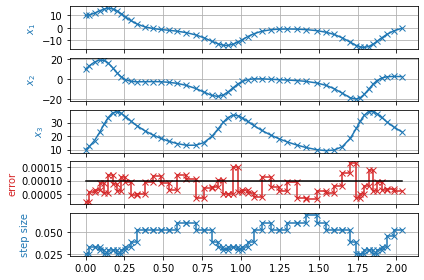

In [12]:
from adaptive.comparison_ode import integrate_env

# Integrate the environment from t0 to t1 using the specified predictor and integrator.
reward, num_evals = integrate_env(predictor, integrator, env, t0=0, t1=2)

print("reward: {}".format(reward))
print("nfev: {}".format(num_evals))
print("mean error: {}".format(np.mean(env.errors)))
print("min error, max error: {}, {}".format(*np.round((np.min(env.errors), np.max(env.errors)), 5)))
print("min stepsize: {}".format(np.min(env.deltas)))
print("max stepsize: {}".format(np.max(env.deltas)))

env.plot()

Now we will compare the performance of our NN time stepper to the popular RK45 (ode45) adaptive Runge Kutta method. (If the next cells takes too long on your machine, set t1 to a smaller value.)

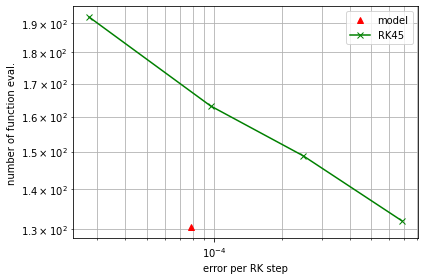

In [13]:
t1 = 200

# evaluate performance of model
reward, num_evals = integrate_env(predictor, integrator, env, t0=t0, t1=t1)
perf_nn = [np.mean(env.errors), num_evals / (t1 - t0)]

# evaluate performance of RK45
from scipy.integrate import solve_ivp  # this function uses RK45 per default

f = LorenzSystem()
perf_rk45 = []
tols = [1e-5, 2.5e-5, 5e-5, 1e-4]  # different tolerances for RK45

for tol in tols:
    f.reset()
    sol = solve_ivp(f, (t0, t1), x0, atol=tol, rtol=tol)
    x_predict = sol.y  # array of x (state) values of the RK45 solution
    t_predict = sol.t  # array of t (time) values of the RK45 solution
    # calculate step-wise absolute errors
    this_errors = []
    for idx in range(t_predict.shape[0] - 1):
        # true solution is approximated with very accurate solve_ivp (tolerance=1e-8)
        x_true = f.solve(t_predict[idx], x_predict[:, idx], t_predict[idx + 1]) 
        this_errors.append(np.linalg.norm(x_predict[:, idx + 1] - x_true))
    perf_rk45.append([np.mean(this_errors), sol.nfev / (t1 - t0)])
perf_rk45 = np.array(perf_rk45)

# plot results
from matplotlib import pyplot as plt
plt.loglog(perf_nn[0], perf_nn[1], 'r^', label='model')
plt.loglog(perf_rk45[:, 0], perf_rk45[:, 1], 'gx-', label='RK45')
plt.legend()
plt.xlabel('error per RK step')
plt.ylabel('number of function eval.')
plt.grid(which='both')
plt.tight_layout()
plt.show()